In [15]:
import torch
import torchvision
from torchinfo import summary
import animal_predictor.going_modular.engine as engine
import matplotlib.pyplot as plt 
import animal_predictor.going_modular.utils as utils
from helper_functions import plot_loss_curves
from torch import nn
import tqdm as notebook_tqdm
from torchvision import transforms
import animal_predictor.going_modular.data_setup as data_setup
import os

In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = os.cpu_count()
device

'cuda'

In [3]:
import os
import zipfile
from pathlib import Path
import requests

img_path = Path(r"C:\Users\Rizzam\Documents\CODES\Python\deep_learning\pytorch\data\animals")
train_dir = img_path / 'train'
test_dir = img_path / 'test'


In [4]:
manual_tranforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [5]:

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [6]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [7]:
train_dataloaders, test_dataloaders, class_names = data_setup.create_dataloaders(train_dir= train_dir, test_dir= test_dir, train_data_transform= manual_tranforms, test_data_transform= auto_transforms, batch_size=32, num_workers= NUM_WORKERS)

In [8]:
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [9]:
summary(model=model, 
        input_size=(32, 3, 224, 224),
        col_names=["input_size"], 
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]
├─Sequential (features)                                      [32, 3, 224, 224]
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]
│    │    └─SiLU (2)                                         [32, 32, 112, 112]
│    └─Sequential (1)                                        [32, 32, 112, 112]
│    │    └─MBConv (0)                                       [32, 32, 112, 112]
│    └─Sequential (2)                                        [32, 16, 112, 112]
│    │    └─MBConv (0)                                       [32, 16, 112, 112]
│    │    └─MBConv (1)                                       [32, 24, 56, 56]
│    └─Sequential (3)                                

In [10]:
for param in model.features.parameters():
    param.requires_grad = False

In [11]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=output_shape,
              bias=True)
).to(device=device)

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr= 0.001)

In [13]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results = engine.train(model= model, train_dataloader= train_dataloaders, test_dataloader= test_dataloaders, loss_fn= loss_fn, optimizer= optimizer, epochs= 5)

  0%|          | 0/5 [00:00<?, ?it/s]

TRAIN LOSS: 0.3390136974294321 | TRAIN ACCURACY: 90.69164691943128


 20%|██        | 1/5 [01:41<06:47, 101.87s/it]

TEST LOSS: 0.18753349590808788 | TEST ACCURACY: 94.71010638297872
Epoch: 1 | train_loss: 0.3390 | train_acc: 90.6916 | test_loss: 0.1875 | test_acc: 94.7101
TRAIN LOSS: 0.17177075841927555 | TRAIN ACCURACY: 94.30539099526067


 40%|████      | 2/5 [03:24<05:07, 102.46s/it]

TEST LOSS: 0.14835997750150395 | TEST ACCURACY: 95.81117021276596
Epoch: 2 | train_loss: 0.1718 | train_acc: 94.3054 | test_loss: 0.1484 | test_acc: 95.8112
TRAIN LOSS: 0.1568938730575886 | TRAIN ACCURACY: 94.5571682464455


 60%|██████    | 3/5 [05:09<03:26, 103.35s/it]

TEST LOSS: 0.15738087258440384 | TEST ACCURACY: 94.35904255319149
Epoch: 3 | train_loss: 0.1569 | train_acc: 94.5572 | test_loss: 0.1574 | test_acc: 94.3590
TRAIN LOSS: 0.14190568790828448 | TRAIN ACCURACY: 94.79413507109005


 80%|████████  | 4/5 [06:52<01:43, 103.33s/it]

TEST LOSS: 0.1399865661292 | TEST ACCURACY: 95.12765957446808
Epoch: 4 | train_loss: 0.1419 | train_acc: 94.7941 | test_loss: 0.1400 | test_acc: 95.1277
TRAIN LOSS: 0.136936760300073 | TRAIN ACCURACY: 95.08293838862559


100%|██████████| 5/5 [08:31<00:00, 102.21s/it]

TEST LOSS: 0.14055434669902983 | TEST ACCURACY: 94.84308510638297
Epoch: 5 | train_loss: 0.1369 | train_acc: 95.0829 | test_loss: 0.1406 | test_acc: 94.8431


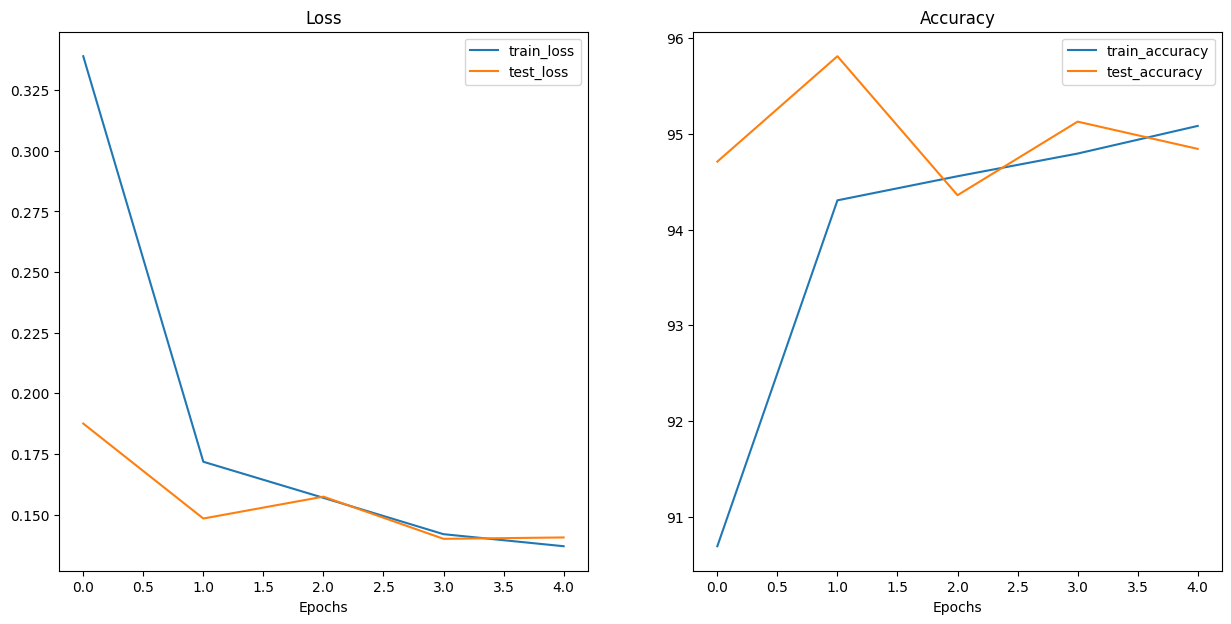

In [16]:
plot_loss_curves(results=results)

In [18]:
utils.save_model(model=model, target_dir= r"C:\Users\Rizzam\Documents\CODES\Python\deep_learning\pytorch\animal_predictor\models", model_name= "efficientnet_b0.pth")

[INFO] Saving model to: C:\Users\Rizzam\Documents\CODES\Python\deep_learning\pytorch\animal_predictor\models\efficientnet_b0.pth
